# Some attempt at Particle Tracking

In [40]:
# Importing things

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import fft

In [41]:
# where is the data?
loc = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/2024-03-11/'
filename = 'Results.csv'

# read in as dataframe
df = pd.read_csv(loc + filename)

# select x and y positions of bead for all 84 frames
x = np.array(df['x'])
y = np.array(df['y'])

Text(0, 0.5, 'y / pixels')

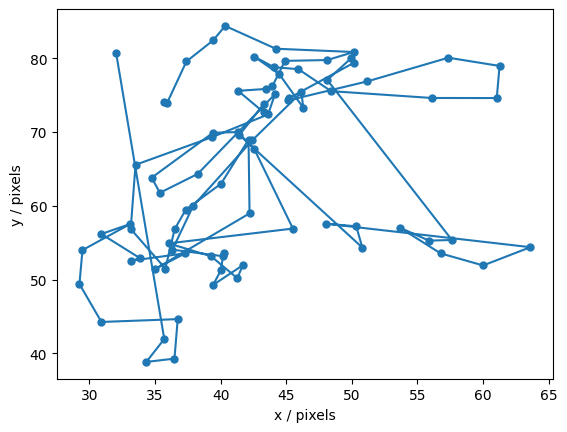

In [42]:
# Plot x and y trajectory

plt.errorbar(x,y, ms = 5, fmt = 'o', linestyle = '-')
plt.xlabel('x / pixels')
plt.ylabel('y / pixels')

<ErrorbarContainer object of 3 artists>

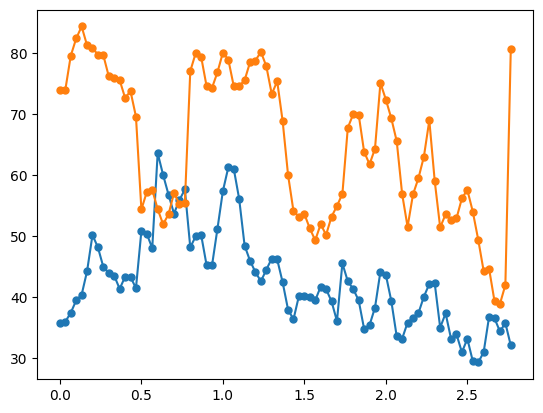

In [43]:
# Frames per second on camera
fps = 30
fps_err = 1

# Set time axis in seconds
time = np.arange(x.size) / 30

# plot x and y over time
plt.errorbar(time,x, ms = 5, fmt = 'o', linestyle = '-', label = 'x / pixels')
plt.errorbar(time,y, ms = 5, fmt = 'o', linestyle = '-', label = 'y / pixels')

C:\Users\abiga\AppData\Local\Temp\ipykernel_3400\2464463682.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(1 / time, fast_four)
c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


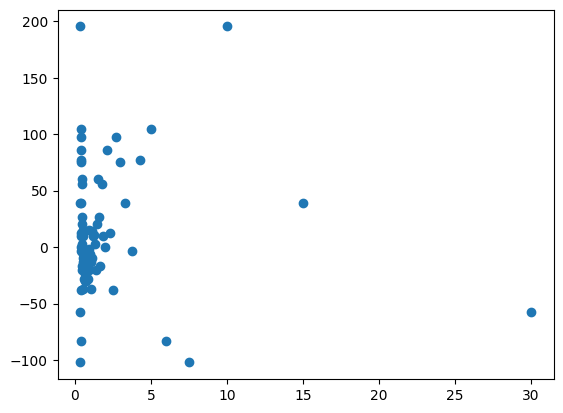

In [44]:
fast_four = fft(y)

plt.scatter(1 / time, fast_four)